In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image

import vgg16

In [2]:
# loads the image in RGB array format
def load_image(filename, height=512, width=512):
    # load image
    image = Image.open(filename)
    # resize image 
    image = image.resize((height, width))
    # convert image to array (height, width, 3)
    image_array = np.asarray(image, dtype=np.float32)
    # add one more dimension to the image inorder to batch multiple image (1, height, width, 3)
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

In [3]:
def display_image(image, height=512, width=512):
    #reshape image array
    image = image.reshape((height, width, 3))
    image = np.clip(image, 0, 255).astype('uint8')
    return Image.fromarray(image)

In [4]:
content_image = load_image('resources/content4.jpg')
style_image = load_image('resources/style3.jpg')

In [5]:
content_image[:, :, :, 0] -= 103.939
content_image[:, :, :, 1] -= 116.779
content_image[:, :, :, 2] -= 123.68
content_image = content_image[:, :, :, ::-1]

In [6]:
style_image[:, :, :, 0] -= 103.939
style_image[:, :, :, 1] -= 116.779
style_image[:, :, :, 2] -= 123.68
style_image = style_image[:, :, :, ::-1]

In [7]:
mixed_image = np.random.randn(*content_image.shape)+128

In [8]:
# variables
height = 512
width = 512

epochs = 40

weight_content=1.5 
weight_style=1.0
weight_denoise=0.3

step_size=10.0

In [9]:
def content_loss(session, model, content, layer_ids):
    
    layers = model.get_output_layerwise(layer_ids)
    
    x = model.graph.get_tensor_by_name('images:0')

    values = session.run(layers, feed_dict={x: content})

    with model.graph.as_default():
        
        loss = []
        
        for value, layer in zip(values, layers):

            content_value = tf.constant(value)

            mixed_value = layer
            
            loss.append(tf.reduce_mean(tf.square(tf.subtract(content_value, mixed_value))))

        return tf.reduce_mean(loss)

In [10]:
# gram matrix - preserves the information of features in style image which are correlated
# flatten the matrix and take the outer product of its transpose with itself
def gram_matrix(tensor):
    
    shape = tensor.get_shape()
    
    num_channels = int(shape[3])
    
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    
    gram = tf.matmul(tf.transpose(matrix), matrix)
    
    return gram

In [11]:
def style_loss(session, model, style, layer_ids):
    
    layers = model.get_output_layerwise(layer_ids)
    
    gram_layers = [gram_matrix(layer) for layer in layers]

    x = model.graph.get_tensor_by_name('images:0')

    values = session.run(layers, feed_dict={x: style})

    with model.graph.as_default():
    
        loss = []

        for value, layer in zip(values, layers):

            content_value = tf.constant(value)
            
            mixed_value = layer

            loss.append(tf.reduce_mean(tf.square(tf.subtract(content_value, mixed_value))))
    
        return tf.reduce_mean(loss)

In [12]:
def denoise_loss(model):
    with model.graph.as_default():
        x = model.graph.get_tensor_by_name('images:0')
        
        loss = tf.reduce_sum(tf.abs(x[:,1:,:,:] - x[:,:-1,:,:])) + \
                tf.reduce_sum(tf.abs(x[:,:,1:,:] - x[:,:,:-1,:]))
            
        return loss

In [13]:
mixed_image = np.random.randn(*content_image.shape)+128

# using the VGG16 model
model = vgg16.VGG16()

session = tf.InteractiveSession(graph=model.graph)

loss_content = content_loss(session, model, content_image,[4])

loss_style = style_loss(session, model, style_image, list(range(13)))

loss_denoise = denoise_loss(model)


adj_content = tf.Variable(1e-10, name='adj_content')
adj_style = tf.Variable(1e-10, name='adj_style')
adj_denoise = tf.Variable(1e-10, name='adj_denoise')


session.run([adj_content.initializer, adj_style.initializer, adj_denoise.initializer])

update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))


loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise

x = model.graph.get_tensor_by_name('images:0')

gradient = tf.gradients(loss_combined, x)


for i in range(epochs):
    
    grad, loss = session.run([gradient, loss_combined], feed_dict={x: mixed_image})
    
    grad = np.squeeze(grad)
    
    step_size_scaled = step_size / (np.std(grad) + 1e-8)
    
    mixed_image -= grad *  step_size_scaled
    
    print(i, loss)


0 2.87129
1 2.59206
2 2.2372
3 2.24319
4 2.1962
5 2.18006
6 2.14904
7 2.14055
8 2.12297
9 2.11652
10 2.10845
11 2.11102
12 2.09604
13 2.10979
14 2.08235
15 2.10191
16 2.06494
17 2.09324
18 2.04955
19 2.08191
20 2.04032
21 2.06909
22 2.03593
23 2.05839
24 2.02856
25 2.04692
26 2.02773
27 2.04192
28 2.02671
29 2.03178
30 2.02507
31 2.02648
32 2.02246
33 2.02304
34 2.01575
35 2.02184
36 2.00664
37 2.01593
38 1.99802
39 2.01402


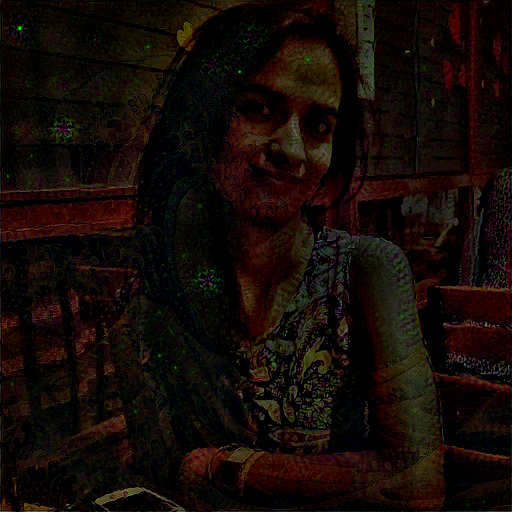

In [14]:
mixed_image = mixed_image[:, :, :, ::-1]
mixed_image[:, :, :, 0] -= 103.939
mixed_image[:, :, :, 1] -= 116.779
mixed_image[:, :, :, 2] -= 123.68
display_image(mixed_image)